<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/DEAP_KappaMu_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install SciencePlots

In [2]:
# !pip install deap

$y = \theta_0 * x + \theta_1$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special as sp
import deap
from deap import algorithms, base, creator, tools
from KappaMu import KappaMu
# %config InlineBackend.figure_format = 'retina'
# plt.style.use('science')/
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
# plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

def evaluation(theta):
  X = np.array([1,2,3,4,5,20,26,7])
  Y = np.array([5,7,9,11,13,43,55,17])

  n = len(X)
  y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

def computePDF(r, kappa, mu, r_hat):
  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /((kappa**((mu - 1)/2)) * np.exp(mu * kappa))
  R = r / r_hat
  B = (R**mu) * np.exp(- mu*(1 + kappa)*(R**2))
  C = sp.iv(mu - 1, 2*mu * R * np.sqrt(kappa*(1 + kappa)))
  PDF = A * B * C / r_hat 
  return PDF

def fitnessFunction(theta):
  # X = np.array([1,2,3,4,5,20,26,7])
  # Y = np.array([5,7,9,11,13,43,55,17])
  X = ku.X
  Y = ku.Y
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [4]:
# kappa = 0.04
# mu = -0.4
# r_hat = 1

In [5]:
# computePDF(ku.X, kappa, mu, r_hat)

In [6]:
ku = KappaMu(kappa=1, mu=4, r_hat=1, numSamples=100, numSim=10**6)

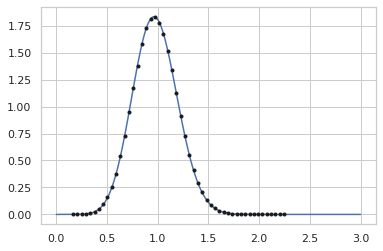

In [7]:
r = np.linspace(0, 3, 3000) # theoretical envelope PDF x axes
plt.plot(r, ku._pdf(r))
plt.plot(ku.X[1:len(ku.X):2], ku.Y[1:len(ku.Y):2], "k.", label='Simulation')

In [8]:
evaluation([0.12726272,0.17092608])

(615.375442293955,)

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

### One individual for $\theta_0$ and other for $\theta_1$
$y = \theta_0x + \theta_1$

In [10]:
np.random.uniform(-1,1, 10)

array([ 0.37233627,  0.02006482, -0.42140286,  0.73553519,  0.45367772,
        0.33752395, -0.94286669,  0.95594216, -0.03703897, -0.03510006])

In [11]:
toolbox = base.Toolbox()

In [12]:
toolbox.register("attr_bool", np.random.uniform, 0, 1)
toolbox.attr_bool()

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.individual()

[0.3771451288065397, 0.6028382508169975, 0.40378273430089473]

In [13]:
toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=3 , indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [14]:
pop = toolbox.population(n=500)

In [15]:
hof = tools.ParetoFront()

In [16]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [17]:
# sortedPop = sorted(pop, key=lambda ind:ind.fitness)

In [18]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,\
                               ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std     	min     	max    
0  	500   	0.670417	0.287981	0.198009	1.55006
1  	316   	(nan+nanj)	nan     	(nan+0j)	(nan+0j)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/deap/base.py:220: RuntimeWarning: invalid value encountered in greater
  if self_wvalue > other_wvalue:
/usr/local/lib/python3.7/dist-packages/deap/base.py:222: RuntimeWarning: invalid value encountered in less
  elif self_wvalue < other_wvalue:


2  	307   	(nan+nanj)	nan     	(nan+0j)	(nan+0j)
3  	303   	(nan+nanj)	nan     	(nan+0j)	(nan+0j)
4  	293   	(nan+nanj)	nan     	(nan+0j)	(nan+0j)
5  	283   	(nan+nanj)	nan     	(nan+0j)	(nan+0j)
6  	322   	(nan+nanj)	nan     	(nan+0j)	(nan+0j)
7  	311   	(nan+nanj)	nan     	(nan+nanj)	(nan+nanj)
8  	320   	(nan+nanj)	nan     	(nan+nanj)	(nan+nanj)
9  	305   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
10 	292   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
11 	292   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
12 	313   	(nan+nanj)	nan     	(nan+nanj)	(nan+nanj)
13 	291   	(nan+nanj)	nan     	(nan+nanj)	(nan+nanj)
14 	287   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
15 	289   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply


16 	311   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
17 	314   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


18 	294   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
19 	289   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
20 	278   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
21 	287   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
22 	284   	(nan+nanj)	nan     	(nan+0j)  	(nan+0j)  
23 	311   	(nan+nanj)	nan     	(nan+nanj)	(nan+nanj)


KeyboardInterrupt: ignored

In [ ]:
print('Current best fitness:', evaluation(tools.selBest(pop, k=1)[0]))

### True function:

$y=2x+3$

$⇒\theta_0=2$

$⇒\theta_1=3$

In [ ]:
len(hof)

In [ ]:
print(r'$\theta_0$ is {}, $\theta_1$ is {} and $\theta_1$ is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))

In [ ]:
import matplotlib.pyplot as plt
import networkx

history = tools.History()
graph = networkx.DiGraph(history.genealogy_tree)
graph = graph.reverse()     # Make the graph top-down
colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
networkx.draw(graph, node_color=colors)
plt.show()

In [ ]:
# record = stats.compile(pop)
# logbook = tools.Logbook()
# logbook.record(gen=0, evals=30, **record)

In [ ]:
# gen = log.select("gen")
# fit_mins = log.select("min")
# size_avgs = log.select("avg")

In [ ]:
# gen, avg = logbook.select("gen", "avg")

In [ ]:
# logbook.header = "gen", "avg", "spam"

In [ ]:
# print(logbook)

In [ ]:
# gen = logbook.select("gen")
# fit_mins = logbook.chapters["fitness"].select("min")
# size_avgs = logbook.chapters["size"].select("avg")

# import matplotlib.pyplot as plt

# fig, ax1 = plt.subplots()
# line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
# ax1.set_xlabel("Generation")
# ax1.set_ylabel("Fitness", color="b")
# for tl in ax1.get_yticklabels():
#     tl.set_color("b")

# ax2 = ax1.twinx()
# line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
# ax2.set_ylabel("Size", color="r")
# for tl in ax2.get_yticklabels():
#     tl.set_color("r")

# lns = line1 + line2
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc="center right")

# plt.show()

In [ ]:
# gen = logbook.select("gen")
# fit_mins = logbook.select("min")
# size_avgs = logbook.select("avg")


In [ ]:
# plt.figure(figsize=(10,7))
# plt.plot(gen, size_avgs, "r-", label="Average Fitness")
# plt.xlabel('Generation')
# plt.ylabel('Average Fitness')
# plt.show()

In [ ]:
# plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")
# plt.xlabel('Generation')
# plt.ylabel('Minimum Fitness')
# plt.show()

In [ ]:
gen

In [ ]:
fit_mins